In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [104]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [105]:
#df1_inc = pd.read_csv('../data/data_int/sbj_1_incremental.csv')
df1_inc = pd.read_csv('../data/data_int/sbj_1_II.csv')
df1_inc.head()

,time,Power,Oxygen,Cadence,HR,RF
0,2,0.0,454.500000,0.0,69.600000,26.300000
1,3,0.0,501.583333,0.0,69.500000,25.083333
2,4,0.0,524.261905,0.0,69.523810,24.166667
3,5,0.0,531.687500,0.0,69.625000,23.437500
4,6,0.0,528.944444,0.0,69.777778,22.833333


In [106]:
df1_inc = df1_inc.iloc[450:2350]
df1_inc

,time,Power,Oxygen,Cadence,HR,RF
450,452,0.0,768.750000,80.0,85.300000,22.700000
451,453,0.0,778.350000,80.0,85.300000,22.566667
452,454,0.0,788.150000,80.0,85.250000,22.500000
453,455,0.0,798.150000,80.0,85.150000,22.500000
454,456,0.0,798.266667,80.0,85.016667,22.566667
...,...,...,...,...,...,...
2345,2347,134.0,2093.950000,90.0,115.000000,46.050000
2346,2348,134.0,2074.350000,90.0,114.950000,46.700000
2347,2349,134.0,2060.050000,90.0,114.850000,47.200000
2348,2350,134.0,2024.250000,90.0,114.700000,47.050000


In [107]:
# df1_win = pd.read_csv('../data/data_int/sbj_1_Wingate.csv')
# df1_win

In [108]:
# df1_t1 = pd.read_csv('../data/data_int/sbj_1_I.csv')
# df1_t1

In [109]:
# df1_t2 = pd.read_csv('../data/data_int/sbj_1_II.csv')
# df1_t2

## Data Cleaning

In [110]:
# Check data types
print(df1_inc.dtypes)
# print(df1_win.dtypes)
# print(df1_t1.dtypes)
# print(df1_t2.dtypes)

time         int64
Power      float64
Oxygen     float64
Cadence    float64
HR         float64
RF         float64
dtype: object


In [111]:
# Check for nulls
print(df1_inc.isnull().sum())
# print(df1_win.isnull().sum())
# print(df1_t1.isnull().sum())
# print(df1_t2.isnull().sum())

time       0
Power      0
Oxygen     0
Cadence    0
HR         0
RF         0
dtype: int64


In [112]:
# Lets look at the df1_inc dataframe, and use HR as the target column
# Try to predict heart rate using all the other features - the goal is to be able to tell when you are putting out enough power to
# make yourself go over your target heart rate. This way you could make sure to keep your power under that threshold.
# Also, if you can look at some data sets with longer (2hr+) training sessions, it would be cool to see how fatigue
# Affects the relationship between power and heart rate.

In [113]:
# Set time as the index for df1_inc
#df1_inc.set_index('time', inplace = True)

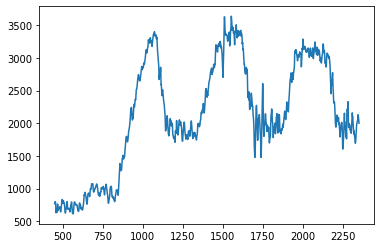

In [114]:
# There is definitely a trend (The test keeps getting harder!)
df1_inc['Oxygen'].plot();

In [115]:
# Add a negligible amount to columns that contain 0 values in order to prevent NaNs when using pct_change
df1_inc['Power'] = df1_inc['Power'] + 0.0001
df1_inc['Cadence'] = df1_inc['Cadence'] + 0.0001

# Set 'time' as the index
#df1_inc.set_index('time', inplace= True)
df1_inc.set_index(pd.to_datetime(df1_inc['time']), inplace= True)

# This should get rid of trend
pct_df = df1_inc.pct_change()

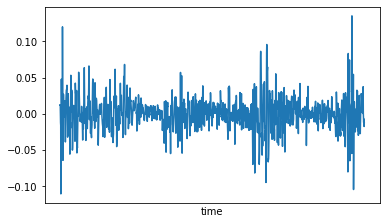

In [116]:
pct_df['Oxygen'].plot();

### Train, Test, Split, and Modeling

In [117]:
df1_inc

,time,Power,Oxygen,Cadence,HR,RF
time,,,,,,
1970-01-01 00:00:00.000000452,452,0.0001,768.750000,80.0001,85.300000,22.700000
1970-01-01 00:00:00.000000453,453,0.0001,778.350000,80.0001,85.300000,22.566667
1970-01-01 00:00:00.000000454,454,0.0001,788.150000,80.0001,85.250000,22.500000
1970-01-01 00:00:00.000000455,455,0.0001,798.150000,80.0001,85.150000,22.500000
1970-01-01 00:00:00.000000456,456,0.0001,798.266667,80.0001,85.016667,22.566667
...,...,...,...,...,...,...
1970-01-01 00:00:00.000002347,2347,134.0001,2093.950000,90.0001,115.000000,46.050000
1970-01-01 00:00:00.000002348,2348,134.0001,2074.350000,90.0001,114.950000,46.700000
1970-01-01 00:00:00.000002349,2349,134.0001,2060.050000,90.0001,114.850000,47.200000


In [118]:
pct_df

,time,Power,Oxygen,Cadence,HR,RF
time,,,,,,
1970-01-01 00:00:00.000000452,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:00:00.000000453,0.002212,0.0,0.012488,0.0,0.000000,-0.005874
1970-01-01 00:00:00.000000454,0.002208,0.0,0.012591,0.0,-0.000586,-0.002954
1970-01-01 00:00:00.000000455,0.002203,0.0,0.012688,0.0,-0.001173,0.000000
1970-01-01 00:00:00.000000456,0.002198,0.0,0.000146,0.0,-0.001566,0.002963
...,...,...,...,...,...,...
1970-01-01 00:00:00.000002347,0.000426,0.0,-0.011752,0.0,0.000000,0.017680
1970-01-01 00:00:00.000002348,0.000426,0.0,-0.009360,0.0,-0.000435,0.014115
1970-01-01 00:00:00.000002349,0.000426,0.0,-0.006894,0.0,-0.000870,0.010707


In [119]:
pct_df.dtypes

time       float64
Power      float64
Oxygen     float64
Cadence    float64
HR         float64
RF         float64
dtype: object

In [120]:
pct_df.isnull().sum()

time       1
Power      1
Oxygen     1
Cadence    1
HR         1
RF         1
dtype: int64

In [121]:
pct_df.dropna(inplace= True)

In [122]:
# Create X and y
X = pct_df.drop(columns= ['Oxygen'])
y = pct_df['Oxygen'].values

In [123]:
X

,time,Power,Cadence,HR,RF
time,,,,,
1970-01-01 00:00:00.000000453,0.002212,0.0,0.0,0.000000,-0.005874
1970-01-01 00:00:00.000000454,0.002208,0.0,0.0,-0.000586,-0.002954
1970-01-01 00:00:00.000000455,0.002203,0.0,0.0,-0.001173,0.000000
1970-01-01 00:00:00.000000456,0.002198,0.0,0.0,-0.001566,0.002963
1970-01-01 00:00:00.000000457,0.002193,0.0,0.0,-0.001960,0.005908
...,...,...,...,...,...
1970-01-01 00:00:00.000002347,0.000426,0.0,0.0,0.000000,0.017680
1970-01-01 00:00:00.000002348,0.000426,0.0,0.0,-0.000435,0.014115
1970-01-01 00:00:00.000002349,0.000426,0.0,0.0,-0.000870,0.010707


In [124]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, shuffle= False)

In [125]:
X_train

,time,Power,Cadence,HR,RF
time,,,,,
1970-01-01 00:00:00.000000453,0.002212,0.0,0.0,0.000000,-0.005874
1970-01-01 00:00:00.000000454,0.002208,0.0,0.0,-0.000586,-0.002954
1970-01-01 00:00:00.000000455,0.002203,0.0,0.0,-0.001173,0.000000
1970-01-01 00:00:00.000000456,0.002198,0.0,0.0,-0.001566,0.002963
1970-01-01 00:00:00.000000457,0.002193,0.0,0.0,-0.001960,0.005908
...,...,...,...,...,...
1970-01-01 00:00:00.000001967,0.000509,0.0,0.0,0.001416,-0.011331
1970-01-01 00:00:00.000001968,0.000508,0.0,0.0,0.001414,-0.001433
1970-01-01 00:00:00.000001969,0.000508,0.0,0.0,0.001412,0.004304


In [126]:
# Scale
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.fit_transform(X_test)

In [127]:
# Create training sequences
train_sequences = TimeseriesGenerator(Z_train, y_train, length=10, batch_size=16)

# Create test sequences
test_sequences = TimeseriesGenerator(Z_test, y_test, length=10, batch_size=16)

In [128]:
train_sequences[0][0].shape

(16, 10, 5)

In [129]:
train_sequences[1][0].shape # shape of first batch

(16, 10, 5)

In [130]:
train_sequences[0][1] # y first batch

array([ 0.02172262, -0.00609575, -0.03365744, -0.01692466,  0.00099727,
        0.01919144,  0.12008026,  0.04988287, -0.0080063 , -0.06403811,
       -0.04820469, -0.01195604,  0.0270575 ,  0.01605074,  0.00566586,
       -0.00444031])

In [131]:
train_sequences[1][1] # y second batch

array([-0.00244587, -0.00043268,  0.00591588,  0.0121925 ,  0.01828102,
        0.0027138 , -0.01249133, -0.02515812, -0.03863899, -0.02974405,
       -0.00767685,  0.01542056,  0.02152682,  0.02728001,  0.03259757,
        0.03333805])

In [132]:
# RNN Design

model = Sequential()

model.add(GRU(4, input_shape=(3, 4), return_sequences=True)) # True if the next layer is RNN
model.add(GRU(4, return_sequences=False)) # False if the next layer is Dense
model.add(Dense(4, activation='relu'))
# output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer=Adam(lr=.0005), metrics= 'mse')

In [133]:
res = model.fit(train_sequences, 
                epochs=500, 
                validation_data=test_sequences, 
                shuffle= False,
                #callbacks = [early_stopping]
               )

Epoch 1/500
95/95 [==============================] - 1s 8ms/step - loss: 0.1907 - mse: 0.1907 - val_loss: 0.1631 - val_mse: 0.1631
Epoch 2/500
95/95 [==============================] - 0s 3ms/step - loss: 0.1608 - mse: 0.1608 - val_loss: 0.1311 - val_mse: 0.1311
Epoch 3/500
95/95 [==============================] - 0s 4ms/step - loss: 0.1203 - mse: 0.1203 - val_loss: 0.0868 - val_mse: 0.0868
Epoch 4/500
95/95 [==============================] - 0s 3ms/step - loss: 0.0945 - mse: 0.0945 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 5/500
95/95 [==============================] - 0s 3ms/step - loss: 0.0648 - mse: 0.0648 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 6/500
95/95 [==============================] - 0s 3ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 7/500
95/95 [==============================] - 0s 3ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 8/500
95/95 [==============================] - 0s 3ms/step - loss: 0.0193 - m

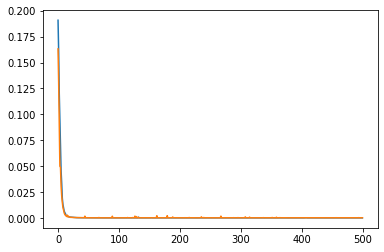

In [134]:
plt.plot(res.history['loss'], label= 'Train')
plt.plot(res.history['val_loss'], label= 'Test')
#plt.ylim(0, .01);

In [135]:
model.evaluate(test_sequences)

24/24 [==============================] - 0s 1ms/step - loss: 4.4152e-04 - mse: 4.4152e-04


[0.00044152027112431824, 0.00044152027112431824]

In [136]:
predictions = model.predict(test_sequences)

In [137]:
#predictions

In [138]:
# Train
#r2_score(Z_train[3:], model.predict(train_sequences))

In [139]:
#model.predict(train_sequences)

In [140]:
# Test

len(model.predict(test_sequences))


370

In [142]:
r2_score(y_test[10:], predictions)

-0.25284684435310667

In [144]:
# https://www.tutorialguruji.com/python/pandas-how-to-revert-pct_change-to-the-original-value-with-the-initial-value/
preds_df.add(1,fill_value=0).cumprod()

,0
0,1.000370
1,1.000758
2,1.001165
3,1.001588
4,1.001999
...,...
365,3.639084
366,3.639934
367,3.640758
368,3.642019


In [145]:
pd.DataFrame(y_test[3:])

,0
0,-0.007523
1,-0.006325
2,0.008210
3,0.004616
4,0.001083
...,...
372,-0.011752
373,-0.009360
374,-0.006894
375,-0.017378


In [146]:
ss.inverse_transform(preds_df)

ValueError: non-broadcastable output operand with shape (370,1) doesn't match the broadcast shape (370,5)

In [ ]:
# This is the original scaled X_train and X_test data
ss.inverse_transform(Z_train)

In [ ]:
ss.inverse_transform(Z_test)

In [ ]:
# ideas - use a batch size that is the size of your entire df, 